In [1]:
using Base: @kwdef
using Parameters: @unpack
using Plots

In [ ]:
1+1

In [2]:
@kwdef struct IZParameter{FT}
    C::FT = 100
    a::FT = 0.03
    b::FT = -2
    d::FT = 100
    k::FT = 0.7
    vthr::FT = -40
    vrest::FT = -60
    vreset::FT = -50
    vpeak::FT = 35
end

@kwdef mutable struct IZ{FT}
    param::IZParameter = IZParameter{FT}()
    N::UInt32
    v::Vector{FT} = fill(param.vrest, N)
    u::Vector{FT} = zeros(N)
    fire::Vector{Bool} = zeros(Bool, N)
end

Juliaでは慣用的に関数名の最後に!を付与したものは、引数の全てまたは一部を変更あるいは破棄することを示す。mutableなコレクションでは、コレクションに要素を追加したり削除する機能が提供されているので、それらを行う関数名の末尾には!がついている

In [3]:
function update!(variable::IZ, param::IZParameter, Ie::Vector, dt)
    @unpack N, v, u, fire = variable
    @unpack C, a, b, d, k, vthr, vrest, vreset, vpeak = param
    @inbounds for i = 1:N
        v[i] += dt/C * (k*(v[i]-vrest)*(v[i]-vthr) - u[i] + Ie[i])
        u[i] += dt * (a * (b * (v[i]-vrest) - u[i]))
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vpeak
        v[i] = ifelse(fire[i], vreset, v[i])
        u[i] += ifelse(fire[i], d, 0)
    end
end;

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(150f0 * ((t .> 50) - (t .> 200)) + 300f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, N), zeros(Float32, nt, N)

# modelの定義
neurons = IZ{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :], uarr[i, :] = neurons.v, neurons.u
end

  0.100457 seconds (819.20 k allocations: 25.690 MiB, 7.81% gc time)


In [5]:
p1 = plot(t, varr[:, 1], color="red")
p2 = plot(t, uarr[:, 1], color="blue")
p3 = plot(t, Ie[:, 1], color="green")
plot(p1, p2, p3,
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Recovery\n current (pA)" "Injection\n current (pA)"],
    layout = grid(3, 1, heights=[0.4, 0.4, 0.2]), guidefont=font(6), legend=false, size=(600,300))

In [6]:
# 記録用
varr_ib, varr_ch = zeros(Float32, nt, N), zeros(Float32, nt, N)
Ie = repeat(500f0 * ((t .> 50) - (t .> 200)) + 700f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# IB neurons
neurons_ib = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 150, a = 0.01, b = 5, k =1.2, d = 130, vrest = -75, vreset = -56, vthr = -45, vpeak = 50))

# CH neurons
neurons_ch = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 50, a = 0.03, b = 1, k =1.5, d = 150, vrest = -60, vreset = -40, vthr = -40, vpeak = 35))

# simulation
@time for i = 1:nt
    update!(neurons_ib, neurons_ib.param, Ie[i, :], dt)
    update!(neurons_ch, neurons_ch.param, Ie[i, :], dt)
    varr_ib[i, :], varr_ch[i, :] = neurons_ib.v, neurons_ch.v
end

  0.060421 seconds (759.89 k allocations: 19.148 MiB, 12.99% gc time)


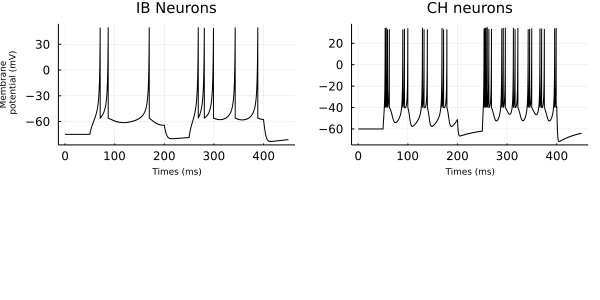

In [7]:
p1 = plot(t, varr_ib[:, 1], color="black", title = "IB Neurons")
p2 = plot(t, varr_ch[:, 1], color="black", title = "CH neurons")
plot(p1, p2, 
    xlabel = ["Times (ms)" "Times (ms)"], 
    ylabel = ["Membrane\n potential (mV)" ""],
    titlefontsize = 10,
    layout = grid(1, 2, widths=[0.5, 0.5], heights=[0.5,]), guidefont=font(6), legend=false, size=(600,300))

以下の三項演算子は、

a ? b : c
普通にif文を使って書くと、

if a
    b
else
    c
end
みたいな感じになります。aが条件になっていて、trueのときにbを、falseのときにcを返します。

下記のモデル自体は**pulse-coupled neural networks(PCNN)**に基づかれており、神経間のシナプス結合の重みは行列Sで与えられて、j番目の神経の発火は自発的にSの要素によって変数vを変化させる

結果から分かることとして、ネットワークは皮質のような非対称性の挙動を示している。つまり、神経はポワソン型のスパイク訓練を行なっていて、その発火率は8Hzほどである。合成発火の挙動としては、最初はalpha rhythm(10Hz)でその後にgamma rhythm(40Hz)に変化する。

**ネットワークはランダムに接続されており、シナプス可塑性はない**けれども、神経の集合体への自己組織は集合的なリズム行動をとっていて、これらは哺乳類のawake状態を支持している。そして、シナプス結合の相対的な強さや視床駆動の強さが異なるタイプの集団行動を生み出している可能性がある。

このモデルニューラルネットの生物学的な妥当性と計算効率については、矛盾はないと主張されている。

In [8]:
# Excitatory neurons, Inhibitory neurons
Ne, Ni = 800, 200;
re, ri = rand(Ne,1), rand(Ni,1)
a = [0.02ones(Ne,1); 0.02 .+ 0.08ri]
b = [0.2ones(Ne,1); 0.25 .- 0.05ri]
c = [-65 .+ 15re.^2; -65ones(Ni,1)]
d = [8 .- 6re.^2; 2ones(Ni,1)]
S = [0.5rand(Ne+Ni,Ne) -rand(Ne+Ni,Ni)] # synaptic weight
v = -65ones(Ne+Ni,1)   # Initial values of v
u = b .* v              # Initial values of u
firings = []            # spike timings

for t=1:1000 # simulation of 1000 ms
    Ie = [5randn(Ne,1); 2randn(Ni,1)] # thalamic input
    fired = findall(v[:, 1] .>= 30) # indices of spikes
    firings = t==1 ? [t .+ 0*fired fired] : [firings; [t .+ 0*fired fired]]
    v[fired] = c[fired]
    u[fired] += d[fired]
    # 発火した神経のインデックスを全ての神経に足し算して和をとって伝えているイメージ
    Ie += sum(S[:,fired], dims=2)
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) # step 0.5 ms for numerical stability
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) 
    u += a .* (b .* v - u)
end

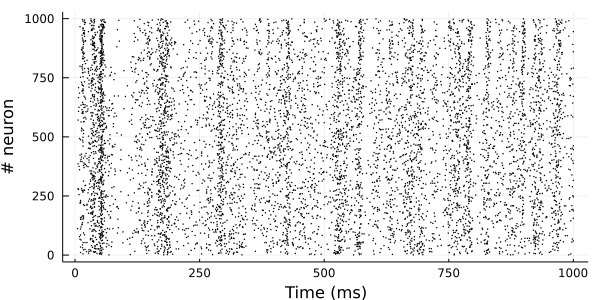

In [9]:
p1 = plot(firings[:,1],firings[:,2],st=:scatter,markersize=1,color="black")
plot(p1, 
    xlabel = "Time (ms)", 
    ylabel = "# neuron",legend=false, size=(600,300))